In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import torch
import torchvision.datasets
from matplotlib import pyplot as plt
from tqdm import tqdm


import utils.metrics
import utils.model
import utils.visualisations
from utils.detection_utils import calculate_mAP

from datasets.voc_detection_dataset import PascalVOCDataset


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
model = torch.load("checkpoints/ssd300.pt", map_location=device).to(device)
# model = torch.load("checkpoints/ssd300_dropout.pt", map_location=device).to(device)

In [4]:
from datasets.transforms import AddGaussianNoise

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

test_dataset = PascalVOCDataset("VOC",
                                split='test',
                                keep_difficult=True,
                                download= True
                                # transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor() ,AddGaussianNoise(std=0.3), torchvision.transforms.ToPILImage()]) 
                                )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                          collate_fn=test_dataset.collate_fn)

Using downloaded and verified file: VOC\VOCtrainval_11-May-2012.tar
Extracting VOC\VOCtrainval_11-May-2012.tar to VOC


  0%|          | 0/460032000 [00:00<?, ?it/s]

100%|██████████| 460032000/460032000 [04:28<00:00, 1716532.36it/s]


Extracting VOC\VOCtrainval_06-Nov-2007.tar to VOC


  0%|          | 0/451020800 [00:00<?, ?it/s]

100%|██████████| 451020800/451020800 [04:39<00:00, 1611737.90it/s]


Extracting VOC\VOCtest_06-Nov-2007.tar to VOC

There are 16551 training images containing a total of 49653 objects. Files have been saved to d:\jiriv\Documents\Práce\confidence\VOC.

There are 4952 test images containing a total of 14856 objects. Files have been saved to d:\jiriv\Documents\Práce\confidence\VOC.


In [68]:
import utils.mc_dropout

def validate(model, test_loader, mc_dropout_iters=0):
    model.to(device)
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py
    true_difficulties = list()

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            if mc_dropout_iters > 0:
                utils.mc_dropout.set_training_mode_for_dropout(model, True)
                locs_list = []
                scores_list = []
                for _ in range(mc_dropout_iters):
                     predicted_locs, predicted_scores = model(images)
                     locs_list.append(predicted_locs)
                     scores_list.append(predicted_scores)
                predicted_locs = torch.stack(locs_list).mean(dim=0)
                predicted_scores = torch.stack(scores_list).mean(dim=0)
                utils.mc_dropout.set_training_mode_for_dropout(model, False)

            else:
                # Forward prop.
                predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                        min_score=0.2, max_overlap=0.5,
                                                                                        top_k=200)

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader, mc_dropout_iters=10)
APs, mAP = calculate_mAP(
    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)
print(APs)
print('\nMean Average Precision (mAP) 50: %.3f' % mAP)

APs, mAP = calculate_mAP(
det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.75)

# Print AP for each class
print(APs)

print('\nMean Average Precision (mAP) 75: %.3f' % mAP)

Evaluating: 100%|██████████| 155/155 [06:34<00:00,  2.55s/it]



Mean Average Precision (mAP) 50: 0.722


In [32]:
from utils.detection_utils import find_jaccard_overlap

def classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels, iou_threshold=0.5):
    TP = []
    FP = []
    FN = []

    for img_idx, (bboxes, labels, scores, gt, gt_labels) in enumerate(zip(det_boxes, det_labels, det_scores, true_boxes, true_labels)):
        idx = torch.argsort(scores, descending=True)
        ious = find_jaccard_overlap(bboxes, gt)
        matched_gt_indexes = []
        matched_boxes_indexes = []
        for true_boxes_iou, box_idx in zip(ious[idx], idx):
            best_iou = 0
            best_iou_idx = None
            for true_boxes_idx, iou in enumerate(true_boxes_iou):
                if iou > best_iou and labels[box_idx] == gt_labels[true_boxes_idx] and true_boxes_idx not in matched_gt_indexes:
                    best_iou = iou
                    best_iou_idx = true_boxes_idx
            if best_iou > iou_threshold:
                TP.append((img_idx,box_idx.item()))
                matched_gt_indexes.append(best_iou_idx)
                matched_boxes_indexes.append(box_idx.item())
        for i, box in enumerate(gt):
            if i not in matched_gt_indexes:
                FN.append((img_idx,i))
        for i, box in enumerate(bboxes):
            if i not in matched_boxes_indexes:
                FP.append((img_idx,i))
    return TP, FP, FN

In [4]:
class detection_model_metrics:
    def __init__(self) -> None:
        self.map50 = []
        self.map75 = []
        self.auroc = []
        self.aupr = []
        self.TP = []
        self.FP = []
        self.FN = []
        self.confidences = []
        self.strengths = []

    def __repr__(self) -> str:
        return str(vars(self))

    def update(self, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, strength):
        self.strengths.append(strength)
        self.confidences.append(torch.cat(det_scores).mean())
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)
        self.map50.append(mAP)
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.75)
        self.map75.append(mAP)
        TP, FP, FN = classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels)
        self.TP.append(len(TP))
        self.FP.append(len(FP))
        self.FN.append(len(FN))

        correct = [1]*len(TP) + [0]*len(FP)
        probs = []
        for img_idx, box_idx in TP+FP:
            probs.append(det_scores[img_idx][box_idx].item())
        metrics = utils.metrics.compute_model_stats(correct, probs, "test")
        self.auroc.append(metrics["auroc"])
        self.aupr.append(metrics["aupr"])

In [ ]:
curves = {
    "Vanilla": detection_model_metrics(),
    "Dropout training": detection_model_metrics(),
    "MC Dropout":detection_model_metrics(),
}


for s in np.arange(0, 0.6, 0.05):
    print(s)

    test_dataset = PascalVOCDataset("VOC",
                                    split='test',
                                    keep_difficult=True,
                                    transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor() ,AddGaussianNoise(std=s), torchvision.transforms.ToPILImage()]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                            collate_fn=test_dataset.collate_fn)

    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader)
    curves["Vanilla"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    # det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader)
    # curves["Dropout training"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    # det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = validate(model, test_loader, mc_dropout_iters=20)
    # curves["MC Dropout"].update(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, s)

    del det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

In [21]:
import pickle
with open("experiments/voc-detection-dropout-noise.pickle", "wb") as f:
    pickle.dump(curves,f)

In [5]:
import pickle
with open("experiments/voc-detection-all-noise.pickle", "rb") as f:
   curves = pickle.load(f)

In [22]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0].item() if isinstance(val[0], torch.Tensor) else val[0]
    df=df.append(row,ignore_index=True)
df=df.drop(["strengths"], axis=1)
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &             label &  map50 &  map75 &  auroc &  aupr &     TP &    FP &    FN &  confidences \\
\midrule
0 &           Vanilla &  0.732 &  0.520 &  0.879 & 0.934 &  10463 &  5904 &  4513 &        0.669 \\
1 &  Dropout training &  0.726 &  0.520 &  0.876 & 0.928 &  10467 &  6300 &  4509 &        0.649 \\
2 &        MC Dropout &  0.727 &  0.521 &  0.875 & 0.930 &  10412 &  5981 &  4564 &        0.652 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_424598/2829502520.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(fl

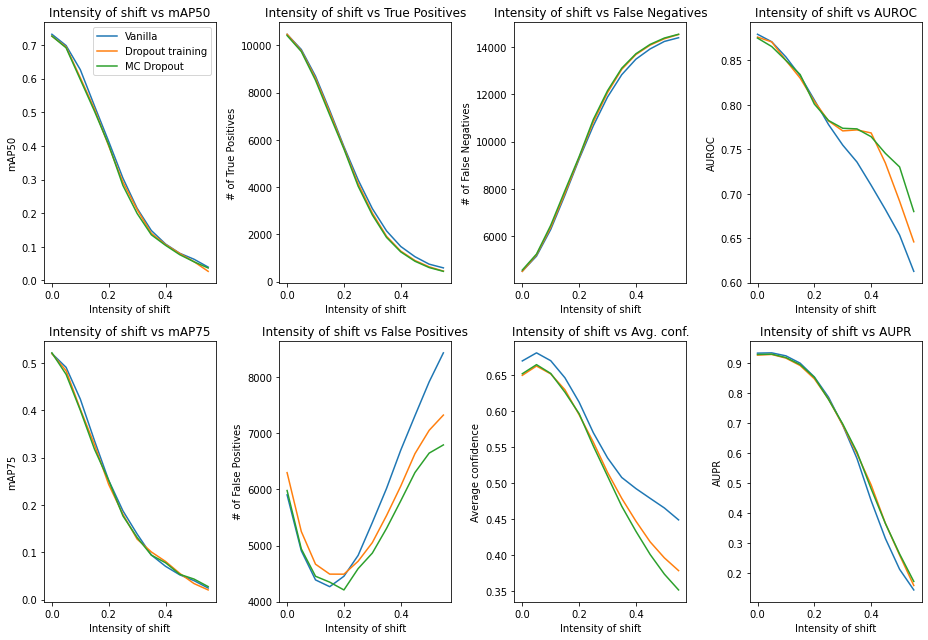

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(13, 9))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.map50, label=name)
    ax.set_title("Intensity of shift vs mAP50")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("mAP50")

    ax = axs[1][0]
    ax.plot(m.strengths, m.map75, label=name)
    ax.set_title("Intensity of shift vs mAP75")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("mAP75")

    ax = axs[0][1]
    ax.plot(m.strengths, m.TP, label=name)
    ax.set_title("Intensity of shift vs True Positives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of True Positives")

    ax = axs[1][1]
    ax.plot(m.strengths, m.FP, label=name)
    ax.set_title("Intensity of shift vs False Positives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of False Positives")

    ax = axs[0][2]
    ax.plot(m.strengths, m.FN, label=name)
    ax.set_title("Intensity of shift vs False Negatives")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("# of False Negatives")

    ax = axs[1][2]
    ax.plot(m.strengths, m.confidences, label=name)
    ax.set_title("Intensity of shift vs Avg. conf.")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][3]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.set_title("Intensity of shift vs AUROC")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("AUROC")

    ax = axs[1][3]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.set_title("Intensity of shift vs AUPR")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("AUPR")

handles, labels = ax.get_legend_handles_labels()
axs[0][0].legend(handles, labels)
fig.tight_layout()

# plt.savefig("figures/voc-detection-gaussian-noise.pdf")